<a href="https://colab.research.google.com/github/MikhailKuklin/time-series-analysis-forecasting/blob/main/notebooks/ts_deep_learning_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries

import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

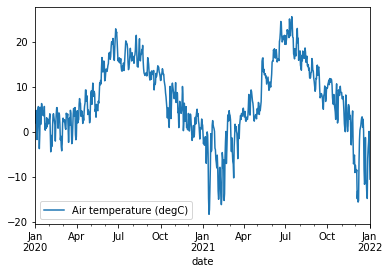

In [3]:
# download data

df = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m","d"]})

df.dropna(axis=0,inplace=True)

df = df.groupby(['date']).mean()

df.index.freq = "D"

df.plot();

In [6]:
# split into train and test sets

train = df.iloc[:673]

test = df.iloc[673:]

In [8]:
# scale 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)